In [1]:
# Import data wrangling libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Import ml modelling libraries
from sklearn.model_selection import train_test_split
import xgboost

# Import explainability libraries
import shap


/Users/atawua/Desktop/Data Science/GitHub/code-snippets/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import the advertising data
df = pd.read_csv("../advertising.csv")
df.columns = df.columns.map(lambda row: "_".join(row.lower().split(" ")))
df

,daily_time_spent_on_site,age,area_income,daily_internet_usage,ad_topic_line,city,male,country,timestamp,clicked_on_ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0
...,...,...,...,...,...,...,...,...,...,...
995,72.97,30,71384.57,208.58,Fundamental modular algorithm,Duffystad,1,Lebanon,2016-02-11 21:49:00,1
996,51.30,45,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,2016-04-22 02:07:01,1
997,51.63,51,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,2016-02-01 17:24:57,1
998,55.55,19,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,2016-03-24 02:35:54,0


In [3]:
# Select a subset of the columns for ease of use
used_features = [
    "daily_time_spent_on_site", 
    "age",
    "area_income", 
    "daily_internet_usage", 
    "male",
]

# Define training data and response variable
X = df[used_features]
y = df["clicked_on_ad"]

In [4]:
# 1. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# 2. Train the model on the training dataset (XGBoost Classifier)
model = xgboost.XGBClassifier().fit(X_train, y_train)

# 3. Test the model on the testing dataset
xgb_predictions = model.predict(X_test)

### 1. Shap Waterfall

In [5]:
def generate_shap_waterfall(row_number, model, test_df, used_features):
    """Helper function to explain contribution of variables to predictions.

    Args:
        row_number (int): The row number of the example to visualise from the data (df)
        model (sklearn model): The trained model.
        test_df (pd.Dataframe): The data to explain the prediction on (usually the test data)
        used_features (list, optional): Features to explore contribution.
    """
    if row_number > len(test_df):
        raise f"row number should be between 0 and {len(test_df)-1}"

    # Get the shap values for the specified dataframe (e.g. test data)
    explainer = shap.Explainer(model, test_df[used_features])
    shap_values = explainer(test_df[used_features])

    # Visualise waterfall for the prediction selected in the row_number argument
    shap.waterfall_plot(shap_values[row_number])

    # Print raw numbers of independent variables
    print(test_df.iloc[row_number][used_features])

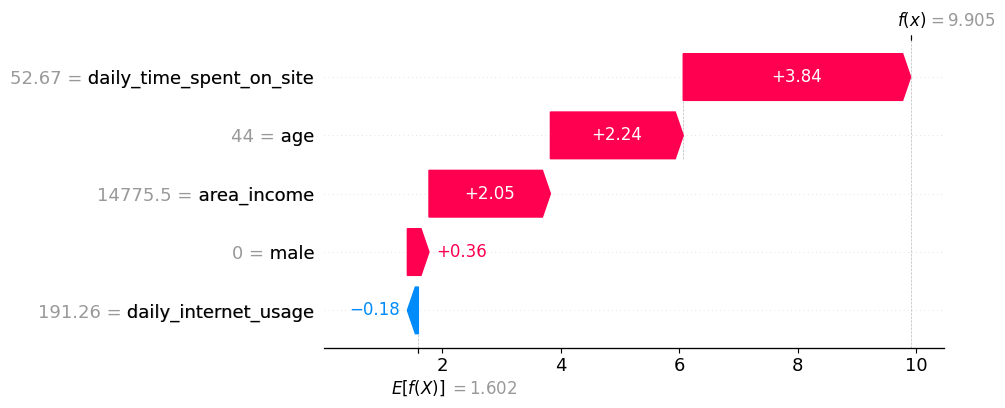

daily_time_spent_on_site       52.67
age                            44.00
area_income                 14775.50
daily_internet_usage          191.26
male                            0.00
Name: 778, dtype: float64


In [7]:
# Apply the shap waterfall function by selecting a data example to visualise
ROW_SELECTOR = 0
generate_shap_waterfall(ROW_SELECTOR, 
    model=model, test_df=X_test, used_features=used_features)

# NOTE:
# 1. f(x) -> Prediction of model
#    For classification, this corresponds to log of odds value.

# 2. E[f(x)] -> Prior expectation under the background data distribution (i.e. mean log of odds)

# 3. Values within arrows -> Shap values

# 4. Plot can be interpreted as follows:
#    a) The base value is the starting point
#    b) The first feature on the left (bottom) bar shows how much it increases (decreases) the predicted value followed by the second feature and so on...
#       - The blue bar shows how much a particular feature decreases the value of the prediction.
#       - The red bar shows how much a particular feature increases the value of the prediction.
#       - Negative values imply probabilities of less than 0.5 that the person clicked the ad
#    c) Continue until reaching the final predicted value (e.g. 0.081).

In [8]:
# NOTE: SHow how to calculate the base values f(x) and E[f(x)]
predictions = model.predict_proba(X_test)[:, 1]     # We use the X_test because this is the dataframe used in the function.
log_odds = np.log(predictions / (1 - predictions))  # Calcualte log odds.

print("This is the f(x):", log_odds[ROW_SELECTOR])
print("This is the E[f(x)]:", np.mean(log_odds))

This is the f(x): 9.904465
This is the E[f(x)]: 1.7476376


### 2. Summary Plot

In [9]:
def generate_shap_summary_plot(model, test_df, used_features):
    """Helper function to explain contribution of variables to predictions.

    Args:
        model (sklearn model): The trained model.
        test_df (pd.Dataframe): The data to explain the prediction on (usually the test data)
        used_features (list, optional): Features to explore contribution.
    """
    # Get the shap values for the specified dataframe (e.g. test data)
    explainer = shap.Explainer(model, test_df[used_features])
    shap_values = explainer(test_df[used_features])

    # Visualise waterfall for the prediction selected in the row_number argument
    shap.summary_plot(shap_values, test_df[used_features])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


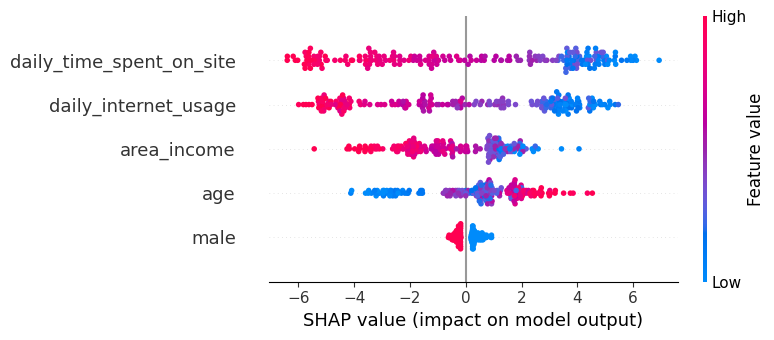

In [10]:
# Apply the shap waterfall function by selecting a data example to visualise
generate_shap_summary_plot(model=model, test_df=X_test, used_features=used_features)

# NOTE:
# - The daily internet usage of a user has the strongest effect on whether that user clicked on an ad.
# - As the daily internet usage increases, a user is less likely to click on an ad.
# - As the daily time spent on the site increases, a user is less likely to click on an ad.
# - As the area income increases, a user is less likely to click on an ad.
# - As the age increases, a user is more likely to click on an ad.
# - If a user is a male, that user is less likely to click on an ad.
